In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14494480343520806349
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1229225032833911937
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Financial/Weekly Fuel Prices dataset.csv')
df.head()

,Date,Petrol (USD),Diesel (USD),Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,09-06-2003,74.59,76.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,16-06-2003,74.47,76.69,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,23-06-2003,74.42,76.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,30-06-2003,74.35,76.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,07-07-2003,74.28,76.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.tail()

,Date,Petrol (USD),Diesel (USD),Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
876,23-03-2020,119.64,123.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN
877,30-03-2020,112.45,118.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
878,06-04-2020,110.23,116.83,NaN,NaN,NaN,NaN,NaN,NaN,NaN
879,13-04-2020,109.27,116.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
880,20-04-2020,108.63,115.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.drop(['Unnamed: 3', 'Unnamed: 4','Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9'],axis=1,inplace=True)
time = pd.date_range(start='9/2/2003',periods=881,freq='W')
df['time_stamp'] = pd.DataFrame(time)
df.drop(['Date'],axis=1,inplace=True)
df = df.set_index('time_stamp')

In [ ]:
df.shape

(881, 2)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 881 entries, 2003-09-07 to 2020-07-19
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Petrol (USD)  881 non-null    float64
 1   Diesel (USD)  881 non-null    float64
dtypes: float64(2)
memory usage: 20.6 KB


In [6]:
df = df[['Petrol (USD)']]
df.columns=['USD']

In [7]:
df.head()

,USD
time_stamp,
2003-09-07,74.59
2003-09-14,74.47
2003-09-21,74.42
2003-09-28,74.35
2003-10-05,74.28


In [8]:
df.tail()

,USD
time_stamp,
2020-06-21,119.64
2020-06-28,112.45
2020-07-05,110.23
2020-07-12,109.27
2020-07-19,108.63


In [9]:
plt.rcParams['figure.figsize'] = [15,8]

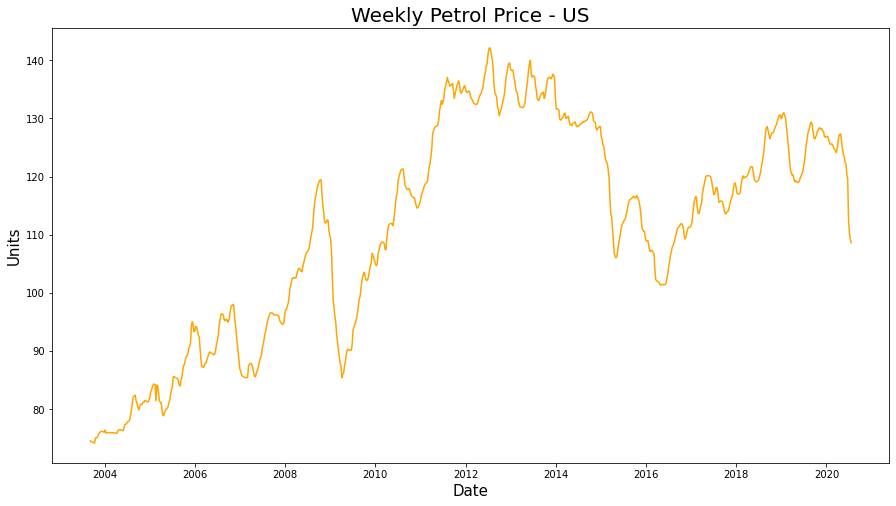

In [ ]:
plt.plot(df,color='orange')
plt.title('Weekly Petrol Price - US',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Units',fontsize=15)
plt.show()

In [10]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [47]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['USD'] = df['USD'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [48]:
#Split data set into testing dataset and train dataset
train_size = 750
train, test =df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 3
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [13]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(747, 1, 3)
(747,)
(128, 1, 3)
(128,)


In [15]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 98 kB 3.0 MB/s 


In [16]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout,SimpleRNN
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [17]:
def build_model(hp):
    model = keras.Sequential()
    model.add(LSTM(hp.Int('rnn_layer',min_value=16,max_value=256,step=16), activation="relu",input_shape=(1,look_back),recurrent_dropout = hp.Choice("first_recurrent_dropout",[0.2,0.3,0.4],default=0.2)))
    model.add(Dense(hp.Int('dense_layer',min_value=16,max_value=160,step=16),activation="relu"))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [18]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=10,
    executions_per_trial=1,
    directory='project',
    project_name='loa_em_1')

In [19]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
rnn_layer (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': None}
first_recurrent_dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4], 'ordered': True}
dense_layer (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 160, 'step': 16, 'sampling': None}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [20]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=34,
             validation_data=(testX, testY))

Trial 10 Complete [00h 00m 36s]
val_mape: 0.8715927004814148

Best val_mape So Far: 0.8497493267059326
Total elapsed time: 00h 07m 28s
INFO:tensorflow:Oracle triggered exit


In [21]:
tuner.results_summary()

Results summary
Results in project/loa_em_1
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
rnn_layer: 48
first_recurrent_dropout: 0.3
dense_layer: 64
Dropout_rate: 0.1
learning_rate: 0.01743491265793592
Score: 0.8497493267059326
Trial summary
Hyperparameters:
rnn_layer: 112
first_recurrent_dropout: 0.4
dense_layer: 64
Dropout_rate: 0.1
learning_rate: 0.0018679925114442324
Score: 0.8715927004814148
Trial summary
Hyperparameters:
rnn_layer: 160
first_recurrent_dropout: 0.4
dense_layer: 144
Dropout_rate: 0.0
learning_rate: 0.0006165831348920453
Score: 0.8728160858154297
Trial summary
Hyperparameters:
rnn_layer: 224
first_recurrent_dropout: 0.2
dense_layer: 112
Dropout_rate: 0.2
learning_rate: 0.014656113106690695
Score: 0.8730162382125854
Trial summary
Hyperparameters:
rnn_layer: 16
first_recurrent_dropout: 0.2
dense_layer: 96
Dropout_rate: 0.2
learning_rate: 0.006986194680700826
Score: 0.879188060760498
Trial summary
Hyperparameters:
rnn

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [22]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 3))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 48)                9984      
                                                                 
 dense (Dense)               (None, 64)                3136      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13,185
Trainable params: 13,185
Non-trainable params: 0
_________________________________________________________________


In [23]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [49]:
model = Sequential()
model.add(LSTM(256,activation='relu',input_dim = 3,recurrent_dropout=0.0))
model.add(Dense(150,activation='relu'))
model.add(Dropout(0.0))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate = 0.0001743491265793592)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 34, epochs = 500)

Epoch 1/500
22/22 [==============================] - 3s 21ms/step - loss: 87.6329 - mape: 87.6329 - val_loss: 81.4795 - val_mape: 81.4795
Epoch 2/500
22/22 [==============================] - 0s 10ms/step - loss: 68.1914 - mape: 68.1914 - val_loss: 64.5125 - val_mape: 64.5125
Epoch 3/500
22/22 [==============================] - 0s 9ms/step - loss: 45.5723 - mape: 45.5723 - val_loss: 43.2229 - val_mape: 43.2229
Epoch 4/500
22/22 [==============================] - 0s 10ms/step - loss: 26.7873 - mape: 26.7873 - val_loss: 20.4382 - val_mape: 20.4382
Epoch 5/500
22/22 [==============================] - 0s 9ms/step - loss: 19.2472 - mape: 19.2472 - val_loss: 7.9449 - val_mape: 7.9449
Epoch 6/500
22/22 [==============================] - 0s 11ms/step - loss: 16.0157 - mape: 16.0157 - val_loss: 6.8991 - val_mape: 6.8991
Epoch 7/500
22/22 [==============================] - 0s 9ms/step - loss: 12.0274 - mape: 12.0274 - val_loss: 4.3221 - val_mape: 4.3221
Epoch 8/500
22/22 [========================

In [50]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [51]:
train_score = model.evaluate(trainX, trainY,verbose=0)
test_score = model.evaluate(testX, testY,verbose=0)

Train MAPE : 1.38 
Test MAPE : 0.86 


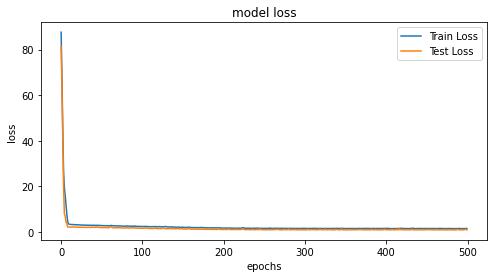

In [52]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print('Train MAPE : %.2f ' % (train_score[1]))
print('Test MAPE : %.2f ' % (test_score[1]))
model_loss(model_history)

In [37]:
import seaborn as sns

In [53]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(747,875)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

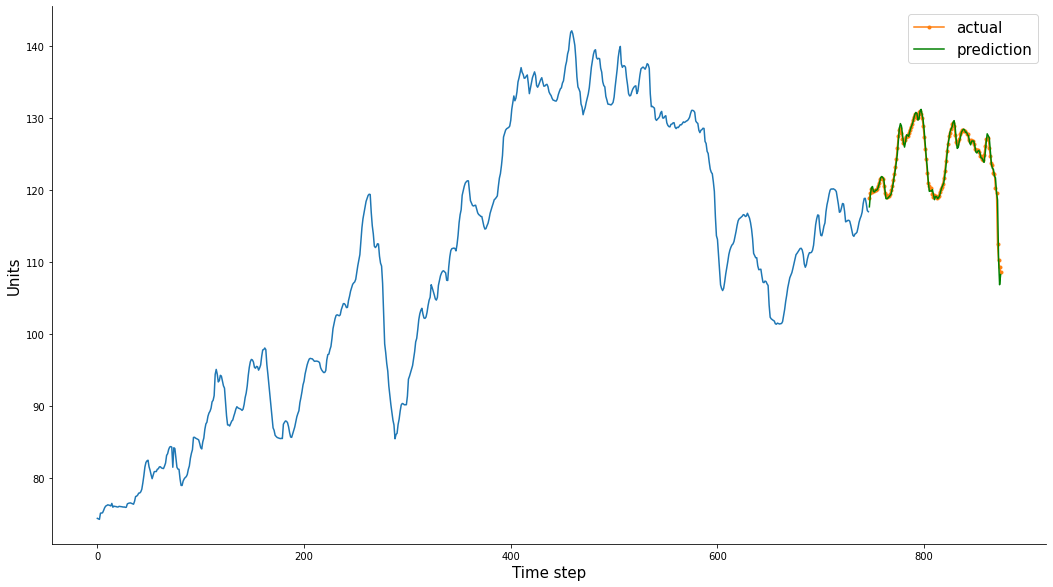

In [54]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)